ConvLSTM

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,Flatten,TimeDistributed,ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

Index(['Abcdin', 'Falabella', 'Lider', 'Paris', 'Ripley', 'claro', 'entel',
       'movistar', 'wom'],
      dtype='object')


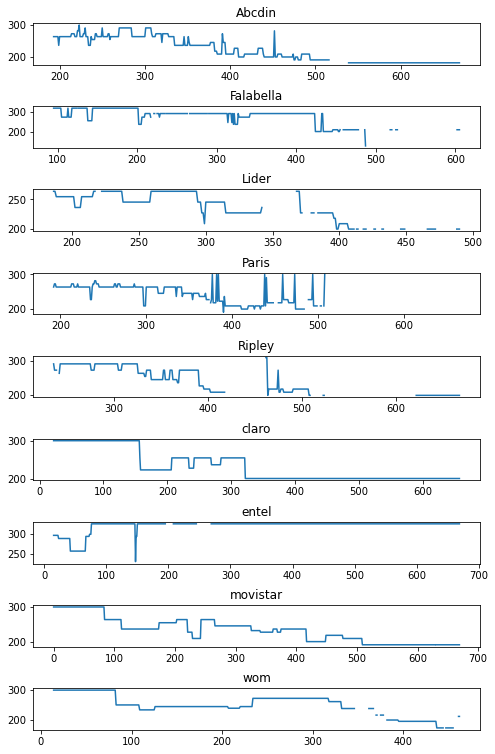

In [37]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
#print(df_wide)
print(df_wide.columns)
i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(wspace=0.4,
                    hspace=1)
plt.show()

In [38]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

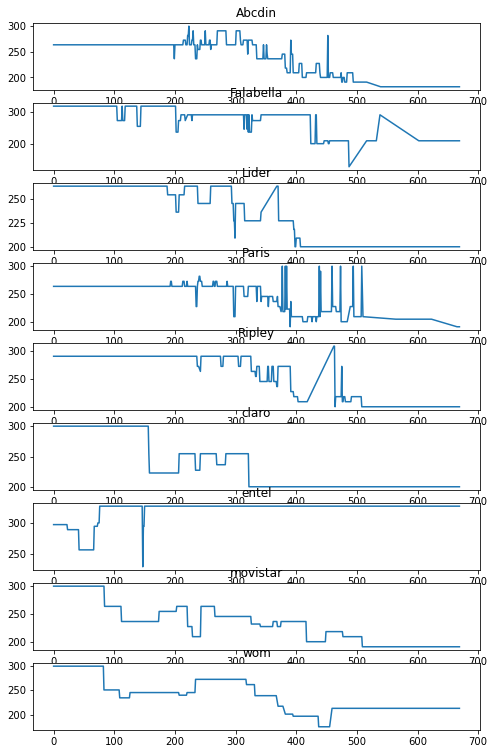

In [39]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [40]:
company = "Abcdin"
#company = "movistar"
raw_seq = df_wide[company]
n_steps = 6 #TEM QUE SER PAR
X, y = split_sequence(raw_seq, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
#print(len(X))
X_train = X[:value]
#print(len(X_train))
y_train = y[:value]
X_test = X[value:]
#print(len(X_test))
y_test = y[value:]

ConvLSTM

In [41]:
n_features = 1
n_seq = 2
n_steps = n_steps//2
X_train = X_train.reshape((X_train.shape[0],n_seq,1,n_steps,n_features))
X_test = X_test.reshape((X_test.shape[0],n_seq,1,n_steps,n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Epoch 1/50
7/7 [==============================] - 3s 47ms/step - loss: 56104.0820 - val_loss: 28082.0371
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 50639.1680 - val_loss: 25289.3359
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 44685.1484 - val_loss: 21490.9043
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 36487.2383 - val_loss: 16306.9902
Epoch 5/50
7/7 [==============================] - 0s 9ms/step - loss: 27164.7949 - val_loss: 11315.1650
Epoch 6/50
7/7 [==============================] - 0s 9ms/step - loss: 18603.8594 - val_loss: 7478.4268
Epoch 7/50
7/7 [==============================] - 0s 9ms/step - loss: 11113.6328 - val_loss: 3558.8296
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 5019.4785 - val_loss: 1326.7120
Epoch 9/50
7/7 [==============================] - 0s 9ms/step - loss: 1667.4183 - val_loss: 241.4624
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss:

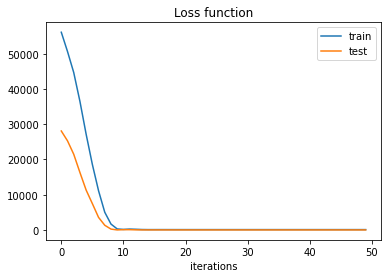

In [42]:
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False)
#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.show()

7/7 [==============================] - 0s 1ms/step
Test MSE: 10.213


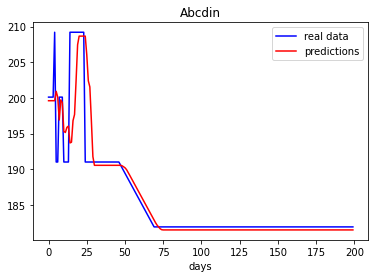

In [43]:
yhat = model.predict(X_test)

mse = mean_squared_error(y_test, yhat)
print('Test MSE: %.3f' % mse)

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.title(company)
plt.xlabel("days")
plt.legend()
plt.show()


In [44]:
import math
from keras.callbacks import EarlyStopping
company = "Abcdin"
#company = "movistar"
percent_train = 0.7
n_features = 1
n_seq = 2
dic={}
raw_seq = df_wide[company]
for n_steps in range(4,31,2):
    X, y = split_sequence(raw_seq, n_steps)
    value = int(len(X)*percent_train)
    X_train = X[:value]
    y_train = y[:value]
    n_steps_1 = n_steps//2
    X_train = X_train.reshape((X_train.shape[0],n_seq,1,n_steps_1,n_features))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_1, n_features)))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    callback = EarlyStopping(monitor='loss', patience=5)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=72, verbose=1, shuffle=False,callbacks=[callback])

    yhat = model.predict(X_train)
    mse = mean_squared_error(y_train, yhat)
    dic[n_steps] = mse

Epoch 1/1000
7/7 [==============================] - 2s 3ms/step - loss: 47369.9922
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 41127.4297
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 35699.7500
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 29215.3203
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 22771.1660
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 16562.1484
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 10815.8594
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 6031.9473
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 2570.2271
Epoch 10/1000
7/7 [==============================] - 0s 3ms/step - loss: 677.8206
Epoch 11/1000
7/7 [==============================] - 0s 4ms/step - loss: 119.5788
Epoch 12/1000
7/7 [==============================] - 0s 3ms/step - loss: 176.6646
Epoch 13/

In [45]:
n_steps_best = min(dic, key=dic.get)
X, y = split_sequence(raw_seq, n_steps_best)
X_train = X[:value]
y_train = y[:value]
X_test = X[value:]
y_test = y[value:]
n_seq = 2
n_steps = n_steps_best//2
X_train = X_train.reshape((X_train.shape[0],n_seq,1,n_steps,n_features))
X_test = X_test.reshape((X_test.shape[0],n_seq,1,n_steps,n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, y_train, epochs=10000, batch_size=72, verbose=1,validation_data=(X_test, y_test), shuffle=False,callbacks=[callback])

Epoch 1/10000
7/7 [==============================] - 2s 48ms/step - loss: 63223.9922 - val_loss: 31593.9883
Epoch 2/10000
7/7 [==============================] - 0s 9ms/step - loss: 54387.8945 - val_loss: 25739.9746
Epoch 3/10000
7/7 [==============================] - 0s 9ms/step - loss: 44240.7773 - val_loss: 20100.1348
Epoch 4/10000
7/7 [==============================] - 0s 8ms/step - loss: 33744.3789 - val_loss: 14394.6055
Epoch 5/10000
7/7 [==============================] - 0s 8ms/step - loss: 23060.6738 - val_loss: 8569.8721
Epoch 6/10000
7/7 [==============================] - 0s 8ms/step - loss: 12537.7324 - val_loss: 3482.5237
Epoch 7/10000
7/7 [==============================] - 0s 9ms/step - loss: 4273.0562 - val_loss: 520.3039
Epoch 8/10000
7/7 [==============================] - 0s 8ms/step - loss: 462.6492 - val_loss: 100.5079
Epoch 9/10000
7/7 [==============================] - 0s 8ms/step - loss: 474.9200 - val_loss: 356.4425
Epoch 10/10000
7/7 [=============================

8
14/14 [==============================] - 0s 1ms/step
train
MAE  :  -0.009788415837572284
MSE  :  95.2074201546002
NRMSE:  0.038337238283051175
test
7/7 [==============================] - 0s 1ms/step
MAE  :  0.04567156309631707
MSE  :  11.328661819228662
NRMSE:  0.017996487708105812


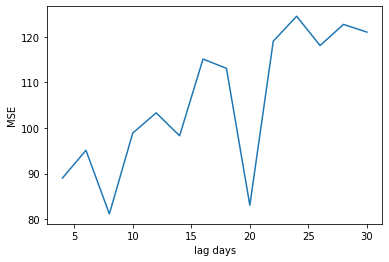

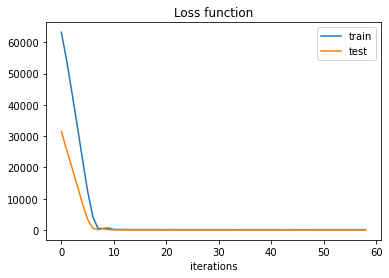

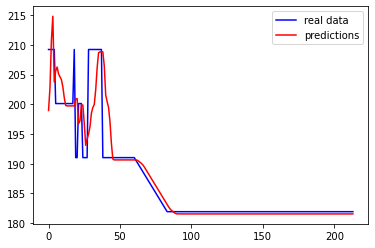

In [46]:
import statistics
print(n_steps_best)
yhat = model.predict(X_train)
yhat = [item for sublist in yhat for item in sublist]
print("train")
print("MAE  : ",sum(yhat - y_train)/len(y_train))
#MSE
print("MSE  : ",sum((yhat - y_train)**2)/len(y_train))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_train)**2)/len(y_train))/(statistics.mean(y_train)) )
print("test")
#para o teste
yhat = model.predict(X_test)
yhat = [item for sublist in yhat for item in sublist]
#MAE
print("MAE  : ",sum(yhat - y_test)/len(y_test))
#MSE
print("MSE  : ",sum((yhat - y_test)**2)/len(y_test))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_test)**2)/len(y_test))/(statistics.mean(y_test)) )

plt.plot(dic.keys(),dic.values())
plt.ylabel("MSE")
plt.xlabel("lag days")
plt.savefig("lstm_conv_"+company+"_lag.png")
plt.show()

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.savefig("lstm_conv_"+company+"_loss.png")
plt.show()

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.legend()
plt.savefig("lstm_conv_"+company+"_test.png")
plt.show()